In [0]:
a=10
b=5
print(a+b)

data = [(1, "John", 28), (2, "Jane", 32), (3, "Jake", 24)]
df = spark.createDataFrame(data, ["ID", "Name", "Age"])
df.show()

15
+---+----+---+
| ID|Name|Age|
+---+----+---+
|  1|John| 28|
|  2|Jane| 32|
|  3|Jake| 24|
+---+----+---+



In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Task 3: Streaming Dataframe
streaming_df = spark.readStream.format("rate").option("rowsPerSecond", 10).load()

# Adding more data to df
enriched_df = streaming_df.withColumn("event_type", expr("CASE WHEN rand() < 0.25 THEN 'purchase' WHEN rand() < 0.5 THEN 'click' WHEN rand() <  0.75 THEN 'view' ELSE 'add_to_cart' END")) \
    .withColumn("user_id", (rand() * 10000).cast("int")) \
    .withColumn("amount", (rand() * 1000).cast("double"))

# 1. Sum of amount per minute
amount_per_minute = enriched_df.withWatermark("timestamp", "1 minute").groupBy(window("timestamp", "1 minute")).agg(sum("amount").alias("total_amount"))

# 2. Sum of amount per event type
amount_per_event_type = enriched_df.groupBy("event_type").agg(sum("amount").alias("total_amount"))


# Start the streaming queries
query1 = amount_per_minute.writeStream.outputMode("complete").format("memory").queryName("amount_per_minute_table").trigger(processingTime="10 seconds").start()

query2 = amount_per_event_type.writeStream.outputMode("complete").format("memory").queryName("amount_per_event_type_table").trigger(processingTime="10 seconds") .start()


# Wait for the streams to finish
# query1.awaitTermination()
# query2.awaitTermination()


In [0]:

query1.stop()

query2.stop()

display(spark.sql("SELECT * FROM amount_per_minute_table"))

display(spark.sql("SELECT * FROM amount_per_event_type_table"))

window,total_amount
"List(2024-09-14T14:12:00Z, 2024-09-14T14:13:00Z)",170740.27425138667
"List(2024-09-14T14:11:00Z, 2024-09-14T14:12:00Z)",270716.5232336259


event_type,total_amount
purchase,103424.03047777068
add_to_cart,41139.04106217358
view,113252.33301180735
click,125254.3253001558


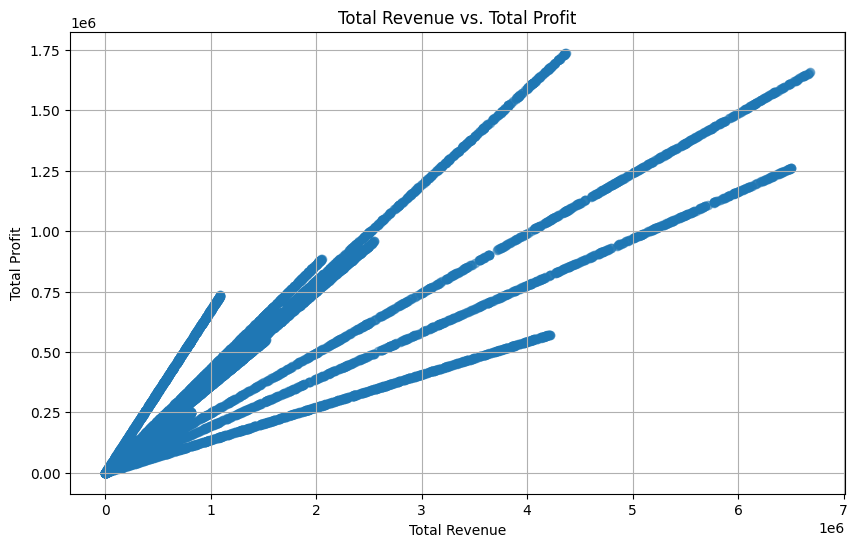

In [0]:
# Task 4
import pandas as pd
import matplotlib.pyplot as plt

dbutils.fs.cp("file:/Workspace/Shared/large_sales_data.csv","dbfs:/FileStore/large_sales_data.csv")

large_sales_df = spark.read.csv("dbfs:/FileStore/large_sales_data.csv", header=True, inferSchema=True).toPandas()

# Scatter plot of Total Revenue vs. Total Profit
plt.figure(figsize=(10, 6))
plt.scatter(large_sales_df["Total Revenue"],large_sales_df["Total Profit"], alpha=0.5)
plt.title("Total Revenue vs. Total Profit")
plt.xlabel("Total Revenue")
plt.ylabel("Total Profit")
plt.grid(True)
plt.show()


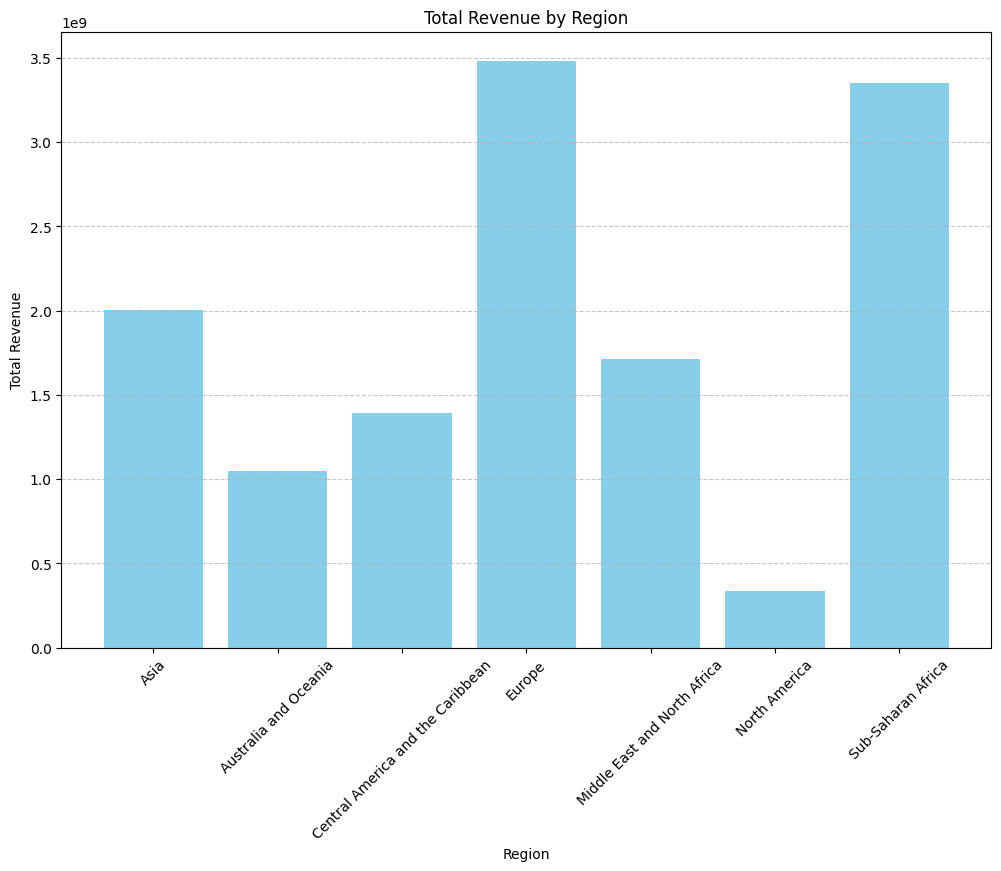

In [0]:
# Aggregate data by Region
revenue_by_region = large_sales_df.groupby("Region")["Total Revenue"].sum().reset_index()

# Bar chart of Total Revenue by Region
plt.figure(figsize=(12, 8))
plt.bar(revenue_by_region["Region"], revenue_by_region["Total Revenue"], color='skyblue')
plt.title("Total Revenue by Region")
plt.xlabel("Region")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


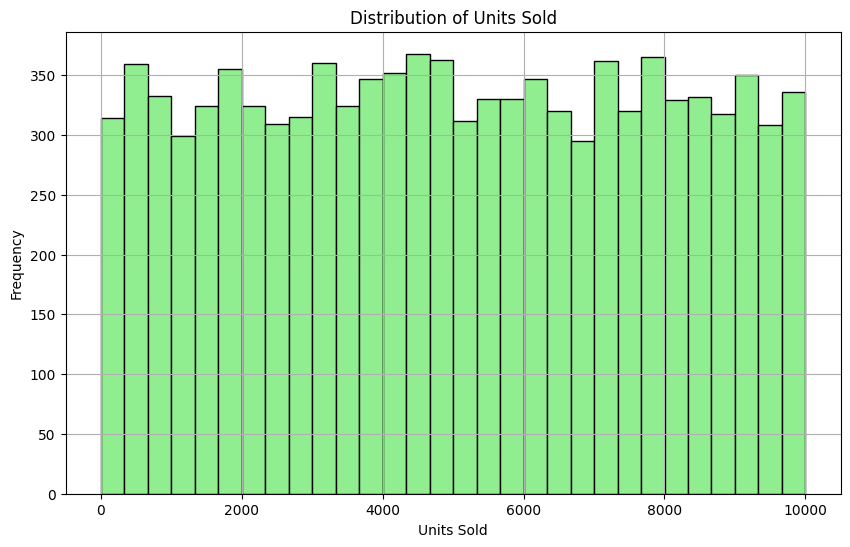

In [0]:
# Histogram of Units Sold
plt.figure(figsize=(10, 6))
plt.hist(large_sales_df["Units Sold"], bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribution of Units Sold")
plt.xlabel("Units Sold")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [0]:
# Task 6

# Reading and writing data in various formats from CSV, JSON, and Parquet, Delta
dbutils.fs.cp("file:/Workspace/Shared/sales1_data.csv", "dbfs:/FileStore/sales1_data.csv")

dbutils.fs.cp("file:/Workspace/Shared/customer_data.json", "dbfs:/FileStore/customer_data.json")

# CSV
df_sales = spark.read.format("csv").option("header","true").load("dbfs:/FileStore/sales1_data.csv")

# JSON
df_customers = spark.read.option("multiline", "true").json("dbfs:/FileStore/customer_data.json")

# Parquet (Read and Write)
df_sales.write.format("parquet").mode("overwrite").save("dbfs:/FileStore/sales_parquet")

df_parquet = spark.read.format("parquet").load("dbfs:/FileStore/sales_parquet")

# Delta (Read and Write)
df_sales.write.format("delta").mode("overwrite").option("mergeSchema", "true").save("dbfs:/FileStore/sales_delta")

sales_df = spark.read.format("delta").load("dbfs:/FileStore/sales_delta")


In [0]:
# Task 7
from pyspark.sql.functions import *
from pyspark.sql.types import *

streaming_df = spark.readStream.format("rate").option("rowsPerSecond", 100).load()

# adding additional columns like event_type, user_id, and amount
streaming_data = streaming_df.withColumn("event_type", expr("CASE WHEN rand() < 0.5 THEN 'purchase' ELSE 'view' END")).withColumn("user_id", (rand() * 10000).cast("int")) \
    .withColumn("amount", (rand() * 1000).cast("double"))

# Sum of amounts per event type
aggregated_data = streaming_data.groupBy("event_type").agg(sum("amount").alias("total_amount"))

# streaming data to memory
query = aggregated_data.writeStream.outputMode("complete").format("memory").queryName("aggregated_streaming_data").start()

# Query the in-memory streaming table to visualize
display(spark.sql("SELECT * FROM aggregated_streaming_data"))

# Grouping data by a time window every 1 minute and event_type
windowed_data = streaming_data.withWatermark("timestamp", "1 minute").groupBy(window("timestamp", "1 minute"), "event_type").agg(sum("amount").alias("total_amount"))

# Write the windowed data to memory for visualization
query_windowed = windowed_data.writeStream.outputMode("complete").format("memory").queryName("windowed_streaming_data").start()

# Query the windowed data for visualization
display(spark.sql("SELECT * FROM windowed_streaming_data"))


event_type,total_amount


window,event_type,total_amount


In [0]:
display(spark.sql("SELECT * FROM aggregated_streaming_data"))

display(spark.sql("SELECT * FROM windowed_streaming_data"))

event_type,total_amount
purchase,30211.262115684123
view,23078.318378733456


Databricks visualization. Run in Databricks to view.

window,event_type,total_amount
"List(2024-09-15T08:10:00Z, 2024-09-15T08:11:00Z)",purchase,1171645.8690808334
"List(2024-09-15T08:10:00Z, 2024-09-15T08:11:00Z)",view,1186314.9719436434


Databricks visualization. Run in Databricks to view.

In [0]:
# Stop streaming queries
query.stop()
query_windowed.stop()

In [0]:
# Task 8
dbutils.fs.cp("file:/Workspace/Shared/largest_sales_data.csv","dbfs:/FileStore/largest_sales_data.csv")

df_largest_sales = spark.read.csv("dbfs:/FileStore/largest_sales_data.csv", header=True, inferSchema=True)

# Creating a delta table
df_largest_sales.write.format("delta").mode("overwrite").option("mergeSchema", "true").save("dbfs:/FileStore/largest_sales_data")

# Registering delta table
spark.sql("CREATE TABLE IF NOT EXISTS largest_sales_data USING DELTA LOCATION 'dbfs:/FileStore/largest_sales_data'")

# Updating
spark.sql("UPDATE largest_sales_data SET `TotalProfit` = `TotalProfit` * 1.5")

# Time Travel
spark.sql("SELECT * FROM largest_sales_data VERSION AS OF 0 LIMIT 10").show()

+--------------------+--------------------+----------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Region|             Country| Item_Type|Sales_Channel|Order_Priority|Order_Date| Order_ID| Ship_Date|Units_Sold|Unit_Price|Unit_Cost|Total_Revenue|Total_Cost|Total_Profit|
+--------------------+--------------------+----------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Europe|          Luxembourg|      Meat|      Offline|             H|2012-04-30|927070415|2012-05-04|      9592|    421.89|   364.69|   4046768.88|3498106.48|    548662.4|
|  Sub-Saharan Africa|        Sierra Leone|    Snacks|       Online|             H|2014-12-20|642765271|2015-01-07|      7382|    152.58|    97.44|   1126345.56| 719302.08|   407043.48|
|              Europe|              France|    Fruits|      Offline|  

In [0]:
# Optimize
spark.sql("OPTIMIZE largest_sales_data")

# Vacuum
spark.sql("VACUUM largest_sales_data RETAIN 168 HOURS")

DataFrame[path: string]

In [0]:
# Task 9
# Managed and unmanaged table
dbutils.fs.cp("file:/Workspace/Shared/large_sales_data.csv","dbfs:/FileStore/large_sales_data.csv")

large_sale_df = spark.read.csv("dbfs:/FileStore/large_sales_data.csv", header=True, inferSchema=True)

large_sale_df.createOrReplaceTempView("large_sales_data_view")

# Managed Table
spark.sql("CREATE TABLE IF NOT EXISTS managed_sales_table USING DELTA AS SELECT * FROM large_sales_data_view")


spark.sql("SELECT * from managed_sales_table LIMIT 10").show()

spark.sql("UPDATE managed_sales_table SET Total_Revenue = Total_Revenue * 1.1")

+--------------------+--------------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Region|             Country|      Item_Type|Sales_Channel|Order_Priority|Order_Date| Order_ID| Ship_Date|Units_Sold|Unit_Price|Unit_Cost|Total_Revenue|Total_Cost|Total_Profit|
+--------------------+--------------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|  Sub-Saharan Africa|                Chad|Office Supplies|       Online|             L|2011-01-27|292494523|2011-02-12|      4484|    651.21|   524.96|   2920025.64|2353920.64|    566105.0|
|              Europe|              Latvia|      Beverages|       Online|             C|2015-12-28|361825549|2016-01-23|      1075|     47.45|    31.79|     51008.75|  34174.25|     16834.5|
|Middle East and N...|            Pakistan|  

In [0]:
# Unmanaged Table
spark.sql("CREATE TABLE IF NOT EXISTS unmanage_sales_table USING DELTA LOCATION 'dbfs:/FileStore/unmanage_sales_table' AS SELECT * FROM large_sales_data_view")

spark.sql("SELECT * FROM unmanage_sales_table LIMIT 10").show()

spark.sql("UPDATE unmanage_sales_table SET Total_Revenue = Total_Revenue * 1.1")

+--------------------+--------------------+---------------+------------+-------------+----------+---------+----------+---------+---------+--------+------------+----------+-----------+
|              Region|             Country|       ItemType|SalesChannel|OrderPriority| OrderDate|  OrderID|  ShipDate|UnitsSold|UnitPrice|UnitCost|TotalRevenue| TotalCost|TotalProfit|
+--------------------+--------------------+---------------+------------+-------------+----------+---------+----------+---------+---------+--------+------------+----------+-----------+
|  Sub-Saharan Africa|                Chad|Office Supplies|      Online|            L|2011-01-27|292494523|2011-02-12|     4484|   651.21|  524.96|  2920025.64|2353920.64|   566105.0|
|              Europe|              Latvia|      Beverages|      Online|            C|2015-12-28|361825549|2016-01-23|     1075|    47.45|   31.79|    51008.75|  34174.25|    16834.5|
|Middle East and N...|            Pakistan|     Vegetables|     Offline|        

In [0]:
# Task 10
# Temporary and Global View
sales_view_df = spark.read.csv("dbfs:/FileStore/large_sales_data.csv", header=True, inferSchema=True)

# Global View
sales_view_df.createOrReplaceGlobalTempView("global_sales_view")

# Temporary View
sales_view_df.createOrReplaceTempView("temp_sales_data_view")

spark.sql("SELECT * FROM temp_sales_data_view LIMIT 10").show()
spark.sql("SELECT * FROM global_temp.global_sales_view LIMIT 10").show()

+--------------------+--------------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Region|             Country|      Item Type|Sales Channel|Order Priority|Order Date| Order ID| Ship Date|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|
+--------------------+--------------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|  Sub-Saharan Africa|                Chad|Office Supplies|       Online|             L|2011-01-27|292494523|2011-02-12|      4484|    651.21|   524.96|   2920025.64|2353920.64|    566105.0|
|              Europe|              Latvia|      Beverages|       Online|             C|2015-12-28|361825549|2016-01-23|      1075|     47.45|    31.79|     51008.75|  34174.25|     16834.5|
|Middle East and N...|            Pakistan|  